In [2]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
# Masks for all possible matches.
filter_masks = jnp.array([
    [
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
    ],
    [
        [1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
    ],
    [
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 1, 1, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
    ],
    [
        [0, 0, 1, 0, 0],
        [0, 0, 1, 0, 0],
        [1, 1, 1, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
    ],
    [
        [1, 1, 1, 0, 0],
        [0, 0, 1, 0, 0],
        [0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
    ],
    [
        [1, 1, 1, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
    ],
    [
        [1, 0, 0, 0, 0],
        [1, 1, 1, 0, 0],
        [1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
    ],
    [
        [0, 1, 0, 0, 0],
        [0, 1, 0, 0, 0],
        [1, 1, 1, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
    ],
    [
        [0, 0, 1, 0, 0],
        [1, 1, 1, 0, 0],
        [0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
    ],
    [
        [1, 1, 1, 0, 0],
        [0, 1, 0, 0, 0],
        [0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
    ],
    [
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
    ],
    [
        [1, 1, 1, 1, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
    ],
    [
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
    ],
    [
        [1, 1, 1, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
    ]
])

# Number of matched elements for each mask.
filter_vals = jnp.array([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 3, 3])

# Type of match for each mask.
filter_types = jnp.array([4, 4, 3, 3, 3, 3, 2, 2, 2, 2, 1, 1, 0, 0])


@jax.jit
def remove_matches(grid: jnp.ndarray) -> tuple[jnp.ndarray, jnp.ndarray]:
    """Remove matches from the game grid.

    Args:
        grid: One-hot encoded game grid. The first dimension represents the
            color, second and third - the element presence.

    Returns:
        A tuple where the first element is the updated grid and the second array
        is the number of matches of each type.
    """
    grid_pad = jnp.pad(grid, 4)
    matches = jnp.zeros(5)

    # Iterate over each filter.
    for filter_mask, filter_val, filter_type in zip(filter_masks, filter_vals, filter_types):

        # Iterate over each grid cell skipping padding.
        for i in range(4, 13):
            for j in range(4, 13):

                # Grid under the filter.
                # grid_slice.shape = (11, 13, 13).
                grid_slice = grid_pad.at[:, i:i + 5, j:j + 5].get()

                # Remove match from the slice if the filter is active.
                # is_filter_active.shape = (11, 1, 1).
                is_filter_active = jnp.sum(grid_slice * filter_mask, axis=[1, 2]) == filter_val
                is_filter_active = is_filter_active[:, jnp.newaxis, jnp.newaxis]

                # grid_slice.shape = (11, 13, 13).
                grid_slice = jnp.logical_xor(grid_slice, is_filter_active * filter_mask)

                # Increment match for each filter activation.
                matches = matches.at[filter_type].add(is_filter_active.sum())

                # Store grid with updated slice.
                grid_pad = grid_pad.at[:, i:i + 5, j:j + 5].set(grid_slice)

    return grid_pad.at[4:-4, 4:13, 4:13].get(), matches

In [ ]:
@jax.jit
def encode_grid(grid):
    """One-hot encode the grid"""
    grid_encoded = jnp.zeros((7, 9, 9))
    vals = jnp.array(range(7)) + 1
    vals = vals[:, jnp.newaxis, jnp.newaxis]
    return jnp.astype(grid == vals, int)


@jax.jit
def decode_grid(grid):
    """Decode one-hot encoded grid."""
    vals = jnp.array(range(7)) + 1
    vals = vals[:, jnp.newaxis, jnp.newaxis]
    return jnp.sum(vals * grid, axis=0)


def plot_grid(grid, ax, vmin=None, vmax=None):
    ax.grid(color="white", linewidth=2)
    ax.set_xticks(jnp.arange(-0.5, 9.5, 1), [])
    ax.set_yticks(jnp.arange(-0.5, 9.5, 1), [])
    ax.imshow(grid, vmin=vmin, vmax=vmax)

In [ ]:
%timeit remove_matches(grid)

2.47 s ± 771 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
remove_matches_jit = jax.jit(remove_matches)
%timeit jax.block_until_ready(remove_matches_jit(grid))

6.29 ms ± 800 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


100%|██████████| 6/6 [00:54<00:00,  9.08s/it]


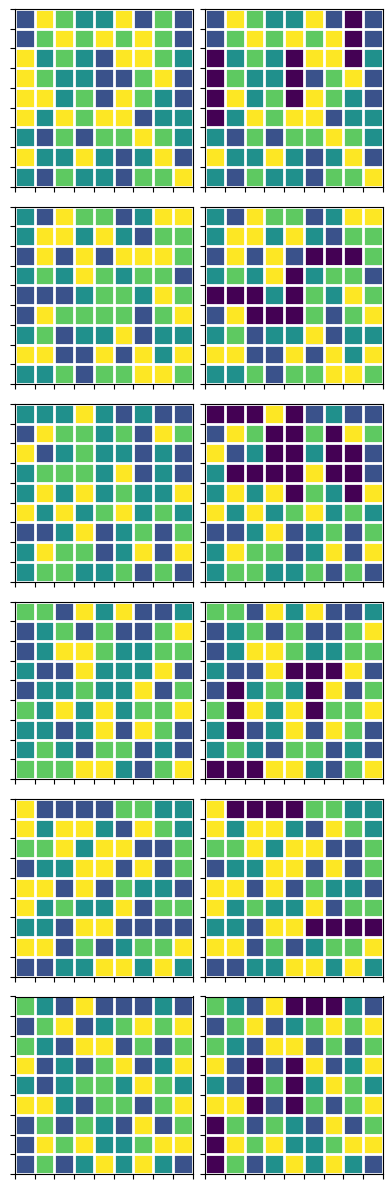

In [ ]:
rng = jnp.random.default_rng(seed=42)

fig, axs = plt.subplots(6, 2, figsize=(4, 12))
for ax0, ax1 in tqdm(axs):
    grid = rng.integers(1, 5, size=(9, 9))
    plot_grid(grid, ax0, vmin=0, vmax=4)

    grid, matches = remove_matches(encode_grid(grid))
    grid = decode_grid(grid)
    plot_grid(grid, ax1, vmin=0, vmax=4)

plt.tight_layout()
plt.show()